In [207]:
import tensorflow as tf
#import tensorflow_addons as tsa
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import os

In [ ]:
%load_ext tensorboard

In [208]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
INPUT_FOLDER_NAME = 'uv'
COLOR_FOLDER_NAME = 'color_rend'
BATCH_SIZE = 1 # TODO: Set larger
EPOCHS = 5

In [209]:
def generate_temporal_train_test_split(temporal_file_pairs, skip):
    num_pairs = len(temporal_file_pairs)
    
    # Separate train and test by selecting evenly spaced samples throughout the dataset
    train_filenames = [temporal_file_pairs[i] for i in range(num_pairs) if (i % skip) != 0]
    test_filenames = [temporal_file_pairs[i] for i in range(num_pairs) if (i % skip) == 0]
    
    return train_filenames, test_filenames

In [210]:
def load_train_test_files(skip):
    # Import file names
    # TODO: Check that every input file has an associated color file
    input_filenames = tf.io.gfile.glob('data/' + INPUT_FOLDER_NAME + '/*')
    color_filenames = tf.io.gfile.glob('data/' + COLOR_FOLDER_NAME + '/*')

    # Sort by file name. Assumed to be numbered temporally.
    input_filenames.sort()
    color_filenames.sort()

    # Create input/label pairs
    input_color_filenames = list(zip(input_filenames, color_filenames))[0:100]

    # Separate train and test sets
    train_filenames, test_filenames = generate_temporal_train_test_split(input_color_filenames, skip)
    
    #print('First 5 train filenames')
    #for f in train_filenames[0:5]:
    #    print(f)

    #print('First 5 test filenames')
    #for f in test_filenames[0:5]:
    #    print(f)
        
    train_filenames = tf.convert_to_tensor(train_filenames)
    test_filenames = tf.convert_to_tensor(test_filenames)
    
    return train_filenames, test_filenames


In [211]:
def load_jpg(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)

    return image

In [212]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = (image / 127.5) - 1

    return image

In [213]:
def resize(image, height, width):
    image = tf.image.resize(image, [height, width],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return image

In [214]:
def random_crop(input_image, color_image):
    stacked_image = tf.stack([input_image, color_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [215]:
@tf.function()
def random_jitter(input_image, color_image):
    # resizing to 286 x 286 x 3
    input_image, color_image = resize(input_image, color_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, color_image = random_crop(input_image, color_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        color_image = tf.image.flip_left_right(color_image)

    return input_image, color_image

In [216]:
def load_image_train(file_tup):#, color_file):
    # TODO: Load tuple as function params
    input_file = file_tup[0]
    color_file = file_tup[1]
    input_image = load_jpg(input_file)
    color_image = load_jpg(color_file)
    
    input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH) 
    color_image = resize(color_image, IMG_HEIGHT, IMG_WIDTH) 
    #input_image, color_image = random_jitter(input_image, color_image)
    #input_image = normalize(input_image)
    color_image = normalize(color_image)
    
    return input_image, color_image

In [217]:
def load_image_test(file_tup):
    # TODO: Load tuple as function params
    input_file = file_tup[0]
    color_file = file_tup[1]
    input_image = load_jpg(input_file)
    color_image = load_jpg(color_file)
 
    input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH) 
    color_image = resize(color_image, IMG_HEIGHT, IMG_WIDTH) 
    #input_image = normalize(input_image)
    color_image = normalize(color_image)

    return input_image, color_image

In [218]:
# Load filenames of train and test data
train_filenames, test_filenames = load_train_test_files(skip=8)

# Prepare train dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_filenames)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(len(train_filenames))
train_dataset = train_dataset.batch(BATCH_SIZE)

# Prepare test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(test_filenames)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

[[[ 65 245   0]
  [ 65 245   0]
  [ 65 245   0]
  [ 66 244   0]
  [ 65 243   0]]

 [[ 65 245   0]
  [ 65 245   0]
  [ 65 245   0]
  [ 66 244   0]
  [ 65 243   0]]

 [[ 65 245   0]
  [ 65 245   0]
  [ 65 245   0]
  [ 66 244   0]
  [ 65 243   0]]

 [[ 65 245   0]
  [ 65 245   0]
  [ 65 245   0]
  [ 66 244   0]
  [ 65 243   0]]

 [[ 65 245   0]
  [ 65 245   0]
  [ 65 245   0]
  [ 66 244   0]
  [ 65 243   0]]]


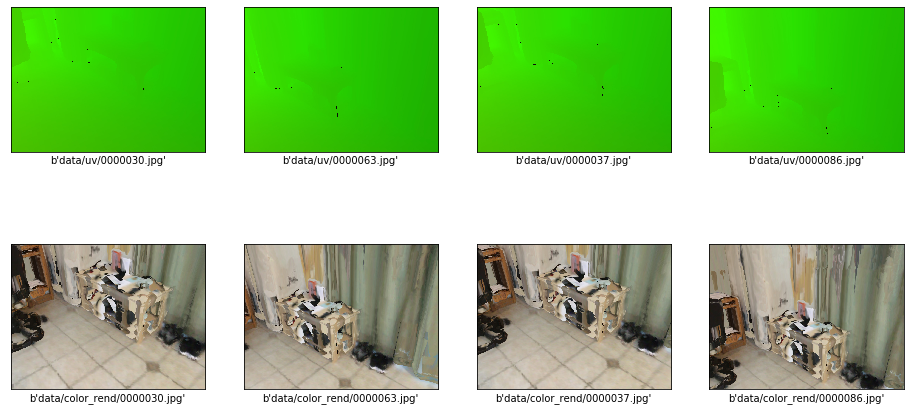

In [219]:
# Display sample of dataset
plt.figure(figsize=(16,8))
for i in range(4):
    r = np.random.randint(len(train_filenames))
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = plt.imread(train_filenames[r,0].numpy(), format='jpeg')
    if i == 0:
        print(img[115:120, 115:120])
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(train_filenames[r,0].numpy())
    plt.subplot(2,4,i+1+4)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = plt.imread(train_filenames[r,1].numpy(), format='jpeg')
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(train_filenames[r,1].numpy())
plt.show()

In [233]:
# https://www.tensorflow.org/guide/keras/custom_layers_and_models
class NeuralTexture(Layer):

    def __init__(self, height, width, channels, **kwargs):
        super(NeuralTexture, self).__init__(**kwargs)
        self.height = height
        self.width = width
        self.channels = channels
        # TODO: Set mean and stddev of initializer
        w_init = tf.random_normal_initializer()
        # TODO: WARNING: Added size 1 to batch dimension but should be something else like '?' or None?
        self.w = tf.Variable(initial_value=w_init(shape=(1, height, width, channels),
                                                  dtype='float32'),
                             trainable=True)
        #self.w = tf.expand_dims(self.w, 0)
        
        # TODO: Should there be a bias as well?

    def call(self, inputs):
        inputs = inputs[:,:,:,0:2] # Remove the third channel
        batch, height, width, channels = inputs.shape
        N = height * width
        inputs = tf.reshape(inputs, shape=[-1, N, channels])
        sampled_tex = tfa.image.interpolate_bilinear(self.w, inputs, indexing='ij', name="sampled_texture")
        sampled_tex = tf.reshape(sampled_tex, shape=[-1, height, width, channels])
        return sampled_tex#inputs#tf.matmul(inputs, self.w)
    
    def get_config(self):
        return {'height': self.height, 'width': self.width, 'channels': self.channels}

In [234]:
def neural_renderer_model_ct(optimizer, loss, pretrained_weights = None,input_size = (IMG_WIDTH,IMG_HEIGHT,3)):
    inputs = Input(input_size)
    
    # TODO: How to initialize texture?
    #texture = tf.keras.backend.variable(tf.random.normal((1024, 1024, 16)), name="texture")(inputs)
    
    texture = NeuralTexture(1024, 1024, 16)(inputs)
    
    #texture = cd(inputs)
    #texture=inputs
    # TODO: Sample texture
    
    lr_alpha = 0.2
    leakyrelu = tf.keras.layers.LeakyReLU(alpha=lr_alpha)
    
    # Encoder Layer 1
    conv1 = Conv2D(64, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')(texture)
    # Encoder Layer 2
    conv2 = Conv2D(128, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    # Encoder Layer 3
    conv3 = Conv2D(256, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # Encoder Layer 4
    conv4 = Conv2D(512, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # Encoder Layer 5
    conv5 = Conv2D(512, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    
    # Decoder Layer 5
    conv6 = Conv2DTranspose(512, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    # Decoder Layer 4
    merge7 = concatenate([conv4,conv6], axis = 3)
    conv7 = Conv2DTranspose(512, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')(merge7)
    # Decoder Layer 3
    merge8 = concatenate([conv3,conv7], axis = 3)
    conv8 = Conv2DTranspose(256, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    # Decoder Layer 2
    merge9 = concatenate([conv2,conv8], axis = 3)
    conv9 = Conv2DTranspose(128, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    # Decoder Layer 1
    merge10 = concatenate([conv1,conv9], axis = 3)
    conv10 = Conv2DTranspose(3, 4, strides=(2, 2), activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_normal')(merge10)
    #conv10 = Conv2DTranspose(64, 4, stride=(2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
    #conv10 = Conv2D(3, 1, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_normal')(conv10)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [235]:
# Loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [236]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(lr = 1e-8)

In [237]:
# Trainable network components
uv_map = tf.ones([256*2, 256*2, 16])
#model = neural_renderer_model(optimizer, loss)
model = neural_renderer_model_ct(optimizer, loss)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
neural_texture_29 (NeuralTextur (None, 256, 256, 2)  16777216    input_30[0][0]                   
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 128, 128, 64) 2112        neural_texture_29[0][0]          
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 64, 64, 128)  131200      conv2d_25[0][0]                  
____________________________________________________________________________________________

In [238]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# https://www.tensorflow.org/guide/keras/train_and_evaluate
model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, callbacks=[tensorboard_callback])

Epoch 1/5
83/87 [===========================>..] - ETA: 14s - loss: 0.2953 - accuracy: 0.3680

In [177]:
# Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

In [178]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [179]:
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [180]:
# Train loop

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_dataset:
        train_step(images, labels)

    for test_images, test_labels in test_dataset:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))

KeyboardInterrupt: 